In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [167]:
class grid():
    def __init__(self, n_x, n_y):
        self.n_x = n_x
        self.n_y = n_y
        self.x_points = np.empty(0)
        self.y_points = np.empty(0)
        self.x_max = 1000
        self.y_max = 1000
        self.grid = {}  
        self.elevation = {}
        self.grid_customers = {}  
        self.n_customers = 0      
        self.customer_points = {}
        self.depot = None
        self.d_ij_indices = {}    
        self.d_ij = None          # distances among customers - interface output for the optimization model
        self.d_ij_extended = None
        self.output_matrix = None
        self.tw_a = None
        self.tw_b = None
        self.load = None
        
        self.create_grid()
        self.grid_dict()
        
    def create_grid(self):
        delta_x = 20
        delta_y = 20
        np.random.seed(1)
        self.x_points = np.linspace(0, self.x_max, self.n_x+1) + np.random.randint(-delta_x, delta_x, self.n_x+1)
        self.y_points = np.linspace(0, self.y_max, self.n_y+1) + np.random.randint(-delta_y, delta_y, self.n_y+1)
        self.x_points[0] = 0; self.x_points[-1] = self.x_max
        self.y_points[0] = 0; self.y_points[-1] = self.y_max
        self.x_points.sort()
        self.y_points.sort()
        
    def grid_dict(self):
        for i in range(self.n_x+1):
            for j in range(self.n_y+1):
                self.grid[(i,j)] = (self.x_points[i], self.y_points[j])
                self.elevation[(i,j)] = 30*np.random.random()
        return self.grid
    
    def time_windows(self, tp='random', min_t=50, max_t=200, k_separation = 0.05, k_overlapped = 0.5):
        tw_a = np.zeros(1, dtype=int); tw_b = np.zeros(1, dtype=int)
        if tp == 'random':
            delta_lower = min_t/2
            delta_upper = delta_lower
            tw_center = np.random.randint(min_t+delta_lower, max_t-delta_upper, self.n_customers)
            tw_a = np.append(tw_a, tw_center - np.random.randint(0, delta_lower, self.n_customers))
            tw_b = np.append(tw_b, tw_center + np.random.randint(0, delta_upper, self.n_customers))
            return tw_a, tw_b
        if tp == 'separated':
            delta_tw = (max_t - min_t)/self.n_customers
            tw_a = np.append(tw_a, np.array([min_t + (i - k_separation)*delta_tw for i in range(self.n_customers)]) )
            tw_b = np.append(tw_b, np.array([min_t + (i + k_separation)*delta_tw for i in range(self.n_customers)]) )
            return tw_a, tw_b
        if tp == 'overlapped':
            tw_c = (max_t - min_t)/2
            tw_interval = 0.5*k_overlapped*tw_c # half base interval (centered halfway between max_t and min_t)
            delta_interval = np.random.randint(0, tw_interval, self.n_customers)
            tw_a = np.append(tw_a, np.array([min_t + tw_c - t for t in sorted(delta_interval)]) )
            tw_b = np.append(tw_b, np.array([min_t + tw_c + t for t in sorted(delta_interval)]) )
            # np.random.shuffle(tw_a); np.random.shuffle(tw_b)
            return tw_a, tw_b
        if tp == 'single':
            tw_a = np.append(tw_a, np.array([min_t for _ in range(self.n_customers)]) )
            tw_b = np.append(tw_b, np.array([max_t for _ in range(self.n_customers)]) )
            return tw_a, tw_b
        
    def plot_grid(self):
        for i in range(self.n_x+1):
            plt.plot([self.x_points[i], self.x_points[i]], [0, self.y_max], color='gray')
        for j in range(self.n_y+1):
            plt.plot([0, self.x_max], [self.y_points[j], self.y_points[j]], color='gray')
        
    def customers(self, n_customers):
        self.n_customers = n_customers
        random.seed(10); customer_points = random.sample(list(self.grid.items()), n_customers)
        self.customer_points = {k:v for k, v in customer_points}
        return self.customer_points
        
    def plot_customer_points(self):
        k = list(self.customer_points.values())
        self.plot_grid()
        for i in range(self.n_customers):
            plt.scatter(k[i][0], k[i][1])
      

    def customers_paths(self, depot):
        ### depot must be an appropriate tuple of coordinate indices of the grid: ex (12, 15): (12th pos. on x - 15th pos. on y)
        self.depot = depot
        nodes = list(self.customer_points.keys())
        nodes.insert(0, depot)
        print(nodes)
        delta_indices = np.zeros((self.n_customers+1, self.n_customers+1), dtype=object)
        for i in range(self.n_customers+1):
            print('node:', i, nodes[i])
            for j in range(self.n_customers+1):
                dx_index = nodes[i][0] - nodes[j][0]
                self.d_ij_indices[(i,j)] = ((nodes[i][0], nodes[i][1]), (nodes[i][0]-dx_index, nodes[i][1]), (nodes[j][0], nodes[j][1]))
        
        self.d_ij = np.zeros((self.n_customers+1, self.n_customers+1))
        self.d_ij_extended = np.zeros((2*self.n_customers+1, 2*self.n_customers+1))
        
        for k, v in self.d_ij_indices.items():
            dx = abs(self.grid[v[1]][0] - self.grid[v[0]][0])
            dy = abs(self.grid[v[2]][1] - self.grid[v[1]][1])
            
            self.d_ij[k[0], k[1]] = dx + dy
        
        return self.d_ij
    
    def create_csv(self):
        elevation = np.zeros(self.n_customers)
        for i, k in enumerate(self.customer_points.keys()):
            elevation[i] = self.elevation[k]
        elevation = np.append(self.elevation[self.depot], elevation)
        self.output_matrix = np.c_[elevation, self.d_ij]
        header = 'elevation'
        for i in range(self.n_customers+1):
            header += ','+str(i)
        np.savetxt('generated_grid_1.csv', self.output_matrix, delimiter=',', header=header, comments='')
        
        return self.output_matrix

In [184]:
G = grid(20, 25)
print(G.grid[(1,3)])
print(G.grid[(5,3)])

(42.0, 123.0)
(235.0, 123.0)


In [185]:
# tt = np.zeros(1, dtype=int)
# t = np.random.randint(40, 60, 4)
# t1 = np.random.randint(5,10 ,4)
# print(t)
# print(t1)
# print(t+t1)
# print('\n')
# print(tt)
# tt = np.append(tt, t1)
# print(tt)

In [186]:
a,b = G.time_windows(tp='single', min_t= 50, max_t=400)
print(a)
print(b)

[0.]
[0.]


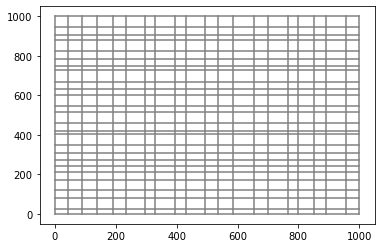

In [187]:
G.plot_grid()

In [188]:
print(np.round(G.x_points, 2))
print(np.round(G.y_points, 2))
print(G.n_x)

[   0.   42.   88.  139.  191.  235.  295.  330.  396.  431.  492.  537.
  586.  655.  700.  767.  798.  850.  891.  958. 1000.]
[   0.   24.   83.  123.  170.  212.  242.  273.  309.  347.  402.  421.
  460.  517.  548.  604.  633.  668.  730.  747.  783.  826.  881.  903.
  944. 1000.]
20


In [189]:
print(G.elevation[(0,0)])
print(G.elevation[(0,5)])

9.465468930181888
29.66583266719484


In [190]:
G.customers(20)
# for i in range(2,5): print(i)

{(1, 7): (42.0, 273.0),
 (16, 23): (798.0, 903.0),
 (19, 0): (958.0, 0.0),
 (0, 15): (0.0, 604.0),
 (8, 3): (396.0, 123.0),
 (18, 5): (891.0, 212.0),
 (19, 9): (958.0, 347.0),
 (10, 24): (492.0, 944.0),
 (6, 8): (295.0, 309.0),
 (1, 9): (42.0, 347.0),
 (20, 13): (1000.0, 517.0),
 (19, 7): (958.0, 273.0),
 (12, 23): (586.0, 903.0),
 (2, 25): (88.0, 1000.0),
 (9, 21): (431.0, 826.0),
 (14, 5): (700.0, 212.0),
 (1, 19): (42.0, 747.0),
 (16, 14): (798.0, 548.0),
 (5, 12): (235.0, 460.0),
 (13, 25): (655.0, 1000.0)}

In [191]:
G.customer_points

{(1, 7): (42.0, 273.0),
 (16, 23): (798.0, 903.0),
 (19, 0): (958.0, 0.0),
 (0, 15): (0.0, 604.0),
 (8, 3): (396.0, 123.0),
 (18, 5): (891.0, 212.0),
 (19, 9): (958.0, 347.0),
 (10, 24): (492.0, 944.0),
 (6, 8): (295.0, 309.0),
 (1, 9): (42.0, 347.0),
 (20, 13): (1000.0, 517.0),
 (19, 7): (958.0, 273.0),
 (12, 23): (586.0, 903.0),
 (2, 25): (88.0, 1000.0),
 (9, 21): (431.0, 826.0),
 (14, 5): (700.0, 212.0),
 (1, 19): (42.0, 747.0),
 (16, 14): (798.0, 548.0),
 (5, 12): (235.0, 460.0),
 (13, 25): (655.0, 1000.0)}

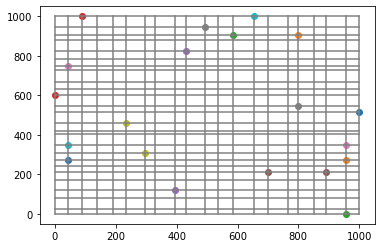

In [192]:
G.plot_customer_points()

In [193]:
G.customers_paths((0,0))

[(0, 0), (1, 7), (16, 23), (19, 0), (0, 15), (8, 3), (18, 5), (19, 9), (10, 24), (6, 8), (1, 9), (20, 13), (19, 7), (12, 23), (2, 25), (9, 21), (14, 5), (1, 19), (16, 14), (5, 12), (13, 25)]
node: 0 (0, 0)
node: 1 (1, 7)
node: 2 (16, 23)
node: 3 (19, 0)
node: 4 (0, 15)
node: 5 (8, 3)
node: 6 (18, 5)
node: 7 (19, 9)
node: 8 (10, 24)
node: 9 (6, 8)
node: 10 (1, 9)
node: 11 (20, 13)
node: 12 (19, 7)
node: 13 (12, 23)
node: 14 (2, 25)
node: 15 (9, 21)
node: 16 (14, 5)
node: 17 (1, 19)
node: 18 (16, 14)
node: 19 (5, 12)
node: 20 (13, 25)


array([[   0.,  315., 1701.,  958.,  604.,  519., 1103., 1305., 1436.,
         604.,  389., 1517., 1231., 1489., 1088., 1257.,  912.,  789.,
        1346.,  695., 1655.],
       [ 315.,    0., 1386., 1189.,  373.,  504.,  910.,  990., 1121.,
         289.,   74., 1202.,  916., 1174.,  773.,  942.,  719.,  474.,
        1031.,  380., 1340.],
       [1701., 1386.,    0., 1063., 1097., 1182.,  784.,  716.,  347.,
        1097., 1312.,  588.,  790.,  212.,  807.,  444.,  789.,  912.,
         355., 1006.,  240.],
       [ 958., 1189., 1063.,    0., 1562.,  685.,  279.,  347., 1410.,
         972., 1263.,  559.,  273., 1275., 1870., 1353.,  470., 1663.,
         708., 1183., 1303.],
       [ 604.,  373., 1097., 1562.,    0.,  877., 1283., 1215.,  832.,
         590.,  299., 1087., 1289.,  885.,  484.,  653., 1092.,  185.,
         854.,  379., 1051.],
       [ 519.,  504., 1182.,  685.,  877.,    0.,  584.,  786.,  917.,
         287.,  578.,  998.,  712.,  970., 1185.,  738.,  393.,  978.

In [194]:
G.d_ij_indices

{(0, 0): ((0, 0), (0, 0), (0, 0)),
 (0, 1): ((0, 0), (1, 0), (1, 7)),
 (0, 2): ((0, 0), (16, 0), (16, 23)),
 (0, 3): ((0, 0), (19, 0), (19, 0)),
 (0, 4): ((0, 0), (0, 0), (0, 15)),
 (0, 5): ((0, 0), (8, 0), (8, 3)),
 (0, 6): ((0, 0), (18, 0), (18, 5)),
 (0, 7): ((0, 0), (19, 0), (19, 9)),
 (0, 8): ((0, 0), (10, 0), (10, 24)),
 (0, 9): ((0, 0), (6, 0), (6, 8)),
 (0, 10): ((0, 0), (1, 0), (1, 9)),
 (0, 11): ((0, 0), (20, 0), (20, 13)),
 (0, 12): ((0, 0), (19, 0), (19, 7)),
 (0, 13): ((0, 0), (12, 0), (12, 23)),
 (0, 14): ((0, 0), (2, 0), (2, 25)),
 (0, 15): ((0, 0), (9, 0), (9, 21)),
 (0, 16): ((0, 0), (14, 0), (14, 5)),
 (0, 17): ((0, 0), (1, 0), (1, 19)),
 (0, 18): ((0, 0), (16, 0), (16, 14)),
 (0, 19): ((0, 0), (5, 0), (5, 12)),
 (0, 20): ((0, 0), (13, 0), (13, 25)),
 (1, 0): ((1, 7), (0, 7), (0, 0)),
 (1, 1): ((1, 7), (1, 7), (1, 7)),
 (1, 2): ((1, 7), (16, 7), (16, 23)),
 (1, 3): ((1, 7), (19, 7), (19, 0)),
 (1, 4): ((1, 7), (0, 7), (0, 15)),
 (1, 5): ((1, 7), (8, 7), (8, 3)),
 (1, 

In [195]:
G.d_ij

array([[   0.,  315., 1701.,  958.,  604.,  519., 1103., 1305., 1436.,
         604.,  389., 1517., 1231., 1489., 1088., 1257.,  912.,  789.,
        1346.,  695., 1655.],
       [ 315.,    0., 1386., 1189.,  373.,  504.,  910.,  990., 1121.,
         289.,   74., 1202.,  916., 1174.,  773.,  942.,  719.,  474.,
        1031.,  380., 1340.],
       [1701., 1386.,    0., 1063., 1097., 1182.,  784.,  716.,  347.,
        1097., 1312.,  588.,  790.,  212.,  807.,  444.,  789.,  912.,
         355., 1006.,  240.],
       [ 958., 1189., 1063.,    0., 1562.,  685.,  279.,  347., 1410.,
         972., 1263.,  559.,  273., 1275., 1870., 1353.,  470., 1663.,
         708., 1183., 1303.],
       [ 604.,  373., 1097., 1562.,    0.,  877., 1283., 1215.,  832.,
         590.,  299., 1087., 1289.,  885.,  484.,  653., 1092.,  185.,
         854.,  379., 1051.],
       [ 519.,  504., 1182.,  685.,  877.,    0.,  584.,  786.,  917.,
         287.,  578.,  998.,  712.,  970., 1185.,  738.,  393.,  978.

In [196]:
print(G.grid_dict()[(0,0)])
print(G.grid_dict()[(1,7)])
print(G.grid_dict()[(16,23)])
print(G.grid_dict()[(19,0)])

(0.0, 0.0)
(42.0, 273.0)
(798.0, 903.0)
(958.0, 0.0)


In [197]:
G.customer_points

{(1, 7): (42.0, 273.0),
 (16, 23): (798.0, 903.0),
 (19, 0): (958.0, 0.0),
 (0, 15): (0.0, 604.0),
 (8, 3): (396.0, 123.0),
 (18, 5): (891.0, 212.0),
 (19, 9): (958.0, 347.0),
 (10, 24): (492.0, 944.0),
 (6, 8): (295.0, 309.0),
 (1, 9): (42.0, 347.0),
 (20, 13): (1000.0, 517.0),
 (19, 7): (958.0, 273.0),
 (12, 23): (586.0, 903.0),
 (2, 25): (88.0, 1000.0),
 (9, 21): (431.0, 826.0),
 (14, 5): (700.0, 212.0),
 (1, 19): (42.0, 747.0),
 (16, 14): (798.0, 548.0),
 (5, 12): (235.0, 460.0),
 (13, 25): (655.0, 1000.0)}

In [198]:
for k in G.customer_points.keys():
    print(k, ' elevation: ', G.elevation[k])

(1, 7)  elevation:  11.057306092958278
(16, 23)  elevation:  18.86524705791573
(19, 0)  elevation:  26.31899292664534
(0, 15)  elevation:  9.065445012474125
(8, 3)  elevation:  25.73215843534322
(18, 5)  elevation:  11.216057161960265
(19, 9)  elevation:  29.78944072912435
(10, 24)  elevation:  14.7222034933324
(6, 8)  elevation:  11.350615165057473
(1, 9)  elevation:  12.41072208597304
(20, 13)  elevation:  20.238206154504727
(19, 7)  elevation:  6.611007034610845
(12, 23)  elevation:  11.713189102128492
(2, 25)  elevation:  20.795836751351644
(9, 21)  elevation:  23.592512468395434
(14, 5)  elevation:  0.12795055221321405
(1, 19)  elevation:  18.840692358207775
(16, 14)  elevation:  3.6664173028156855
(5, 12)  elevation:  10.422417984018152
(13, 25)  elevation:  21.864447958354617


In [199]:
out = G.create_csv()
out

array([[1.40171570e+01, 0.00000000e+00, 3.15000000e+02, 1.70100000e+03,
        9.58000000e+02, 6.04000000e+02, 5.19000000e+02, 1.10300000e+03,
        1.30500000e+03, 1.43600000e+03, 6.04000000e+02, 3.89000000e+02,
        1.51700000e+03, 1.23100000e+03, 1.48900000e+03, 1.08800000e+03,
        1.25700000e+03, 9.12000000e+02, 7.89000000e+02, 1.34600000e+03,
        6.95000000e+02, 1.65500000e+03],
       [1.10573061e+01, 3.15000000e+02, 0.00000000e+00, 1.38600000e+03,
        1.18900000e+03, 3.73000000e+02, 5.04000000e+02, 9.10000000e+02,
        9.90000000e+02, 1.12100000e+03, 2.89000000e+02, 7.40000000e+01,
        1.20200000e+03, 9.16000000e+02, 1.17400000e+03, 7.73000000e+02,
        9.42000000e+02, 7.19000000e+02, 4.74000000e+02, 1.03100000e+03,
        3.80000000e+02, 1.34000000e+03],
       [1.88652471e+01, 1.70100000e+03, 1.38600000e+03, 0.00000000e+00,
        1.06300000e+03, 1.09700000e+03, 1.18200000e+03, 7.84000000e+02,
        7.16000000e+02, 3.47000000e+02, 1.09700000e+03